In [13]:
import metaheuristics
import graph_handler
import fiduccia
import graph_handler 
import networkx as nx
import random
import math
import numpy as np
import time
import matplotlib.pyplot as plt



In [21]:
G = graph_handler.parse_graph("res/Graph500.txt", False)
mut = 0
partition = metaheuristics.createRandomPartition(G)

cuts = []
mutations = []
for mut in range(0, int(len(G.nodes()) / 2),2):
    mutations.append(mut)
    _,cut,_,_ = metaheuristics.ils(G.copy(), startNumberOfMutations = mut, partition = partition)
    cuts.append(cut)


[50, 50, 50, 50, 46, 50, 50, 50, 50, 50, 50, 50, 50, 47, 47, 50, 49, 45, 48, 50, 42, 46, 49, 50, 50, 45, 49, 49, 41, 50, 50, 50, 25, 27, 43, 42, 47, 50, 50, 35, 50, 50, 31, 9, 32, 32, 30, 44, 36, 25, 30, 50, 30, 40, 28, 19, 50, 46, 50, 30, 28, 34, 40, 26, 24, 24, 35, 38, 19, 22, 37, 19, 28, 25, 23, 44, 39, 50, 35, 29, 36, 22, 32, 35, 50, 27, 50, 34, 50, 28, 24, 41, 22, 40, 39, 50, 48, 50, 45, 50, 33, 50, 50, 49, 50, 46, 50, 50, 50, 49, 46, 50, 50, 46, 49, 49, 50, 50, 50, 50, 50, 50, 49, 50, 50]
[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100, 102, 104, 106, 108, 110, 112, 114, 116, 118, 120, 122, 124, 126, 128, 130, 132, 134, 136, 138, 140, 142, 144, 146, 148, 150, 152, 154, 156, 158, 160, 162, 164, 166, 168, 170, 172, 174, 176, 178, 180, 182, 184, 186, 188, 190, 192, 194, 196, 198, 200, 202, 204, 206, 208, 210, 212, 214, 216, 218, 220,

Text(0.5, 1.0, 'ILS cutsize')

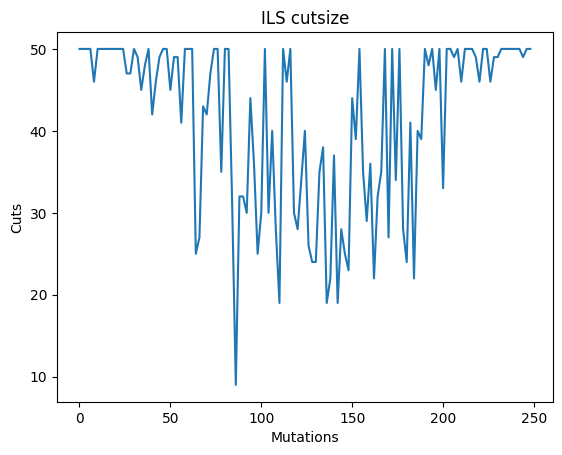

In [22]:
print(cuts)
print(mutations)

plt.plot(mutations, cuts)
plt.xlabel('Mutations')
plt.ylabel('Cuts')
plt.title('ILS cutsize')



